smm4h all data: (1107, 2)
SOC count in CADEC:  soc_code
10037175    287
10018065    235
10029205    212
10017947     63
10028395     58
10022891     54
10027433     48
10040785     28
10038738     22
10022117     16
10015919     16
10038604     10
10047065     10
10021428      8
10041244      7
10007541      7
10038359      6
10021881      5
10013993      4
10019805      2
10042613      2
10029104      2
10077536      1
10010331      1
0             1
10014698      1
Name: count, dtype: Int64
CADEC top3 in SMM4H:                             ade  soc_code
3                            AD  10037175
4                         focus  10029205
5                          died  10018065
8                        dreams  10037175
10                   withdrawal  10018065
...                         ...       ...
1695       talk a mile a minute  10037175
1698     can't go back to sleep  10037175
1703                 chest hurt  10018065
1704   got ten minutes of sleep  10037175
1708  never have an

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\fd\anaconda3\envs\torch\Lib\site-packages\transformers\tokenization_utils_base.py:2888: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a

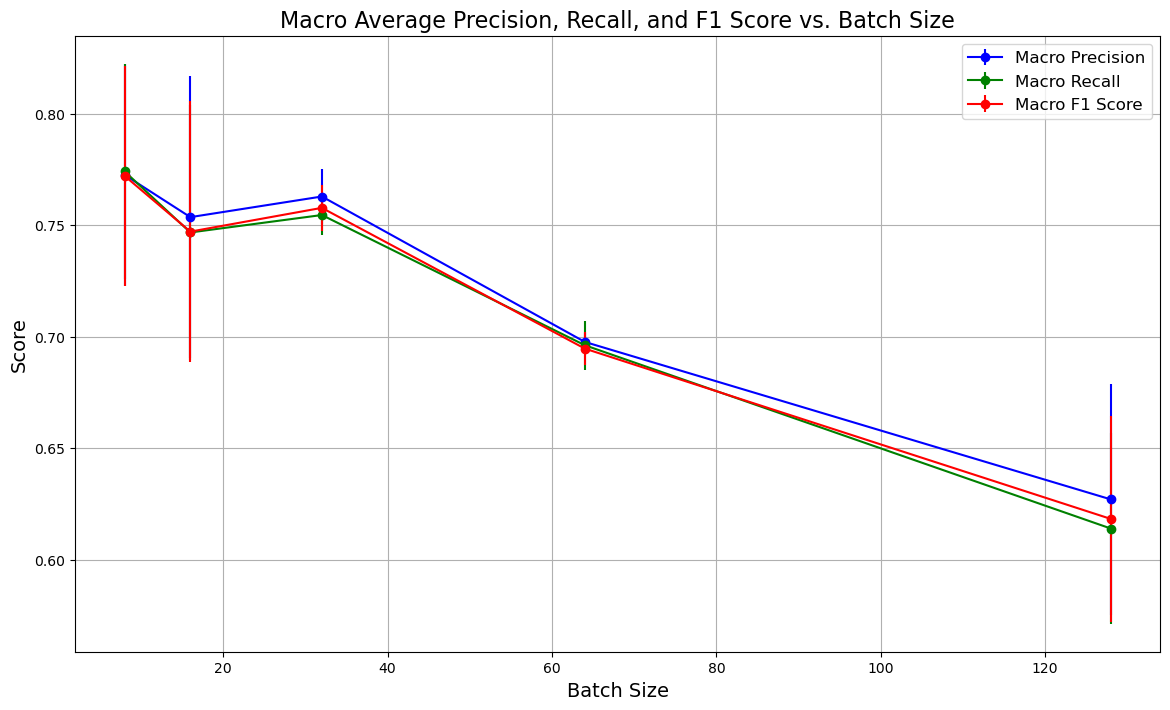

In [2]:
#install packages
!pip install transformers
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from sklearn.model_selection import train_test_split

import numpy as np
import random


import logging
import random
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

from tqdm import tqdm

#data split function
def custom_train_val_test_split(X, y, test_size=0.1, val_size=0.1, random_state=None):
    classes, counts = np.unique(y, return_counts=True)

    # Find classes with only one or two instances
    small_classes = classes[counts < 5]

    # Separate out the instances of small classes
    large_class_mask = ~np.isin(y, small_classes)
    X_large = X[large_class_mask]
    y_large = y[large_class_mask]
    X_small = X[~large_class_mask]
    y_small = y[~large_class_mask]

    # Perform stratified split on the larger classes dataset
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_large, y_large, test_size=(val_size + test_size),
        random_state=random_state, stratify=y_large
    )

    # Split the remaining data into validation and testing sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_size / (test_size + val_size)),
        random_state=random_state, stratify=y_temp
    )

    # Randomly assign instances of small classes to training, validation, or testing sets
    for i in range(len(X_small)):
        rand_choice = np.random.rand()
        if rand_choice < test_size:
            X_test = np.vstack([X_test, X_small[i]])
            y_test = np.hstack([y_test, y_small[i]])
        elif rand_choice < (test_size + val_size):
            X_val = np.vstack([X_val, X_small[i]])
            y_val = np.hstack([y_val, y_small[i]])
        else:
            X_train = np.vstack([X_train, X_small[i]])
            y_train = np.hstack([y_train, y_small[i]])

    return X_train, X_val, X_test, y_train, y_val, y_test


#evaluation
def accuracy_per_class(predictions, true_vals):
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()

    accuracy_dict = {}
    count_dict = {}

    for label in np.unique(labels_flat):
        y_preds = pred_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        accuracy_dict[label] = np.sum(y_preds == y_true) / len(y_true) if len(y_true) > 0 else 0
        count_dict[label] = len(y_true)

    return accuracy_dict, count_dict

# Configure logging
logging.basicConfig(filename='smm4h_top3_finetuning_batchsize_test.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

class TQDMLoggingWrapper(tqdm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.logger = logger

    def display(self, msg=None, pos=None):
        if msg is not None:
            self.logger.info(msg)
        super().display(msg, pos)

    def update(self, n=1):
        super().update(n)
        desc = self.format_dict.get('desc', 'No description')
        postfix = self.format_dict.get('postfix', '')
        self.logger.info(f'{desc} - {postfix}')

    def set_description(self, desc=None, refresh=True):
        super().set_description(desc, refresh)
        if desc:
            self.logger.info(f'Set description: {desc}')


# Function to evaluate the model
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

#Read smm4h data from git:
#https://raw.githubusercontent.com/FANMISUA/ADE_Norm/main/Data/smm4h_soc.tsv
# URL of the CSV file
smm4h_csv_url = "https://raw.githubusercontent.com/FANMISUA/ADE_Norm/main/Data/smm4h_soc.tsv"

# Read the CSV file into a pandas DataFrame
smm4h_column_names = ["ade", "soc_code"]
smm4h_all = pd.read_csv(smm4h_csv_url,names=smm4h_column_names, sep = '\t', header=None)

smm4h_all = smm4h_all[smm4h_all['soc_code'] != 0]
smm4h_all['soc_code'] = pd.to_numeric(smm4h_all['soc_code'], errors='coerce').astype('Int64')

# Display the first few rows of the DataFrame and the shape
# print(smm4h_all.head)
# print(smm4h_all.shape)


# Remove duplicate rows based on the 'ade' column
smm4h_unique = smm4h_all.drop_duplicates(subset='ade')


# Display the resulting DataFrame
print("smm4h all data:",smm4h_unique.shape)
# Count occurrences of each 'soc_code'
soc_code_counts = smm4h_unique['soc_code'].value_counts()
# Sort the counts from high to low and print the result
print("SOC count in CADEC: ",soc_code_counts)

#get top 3 of the SMM4H list
#['10037175','10018065','10029205','10017947','10028395','10022891']
top3SMM4H = [10037175, 10018065,10029205]
# top6SMM4H = [10037175,10018065,10029205,1001794,10028395,10022891]

top3label_dict = {
    10037175: 0,
    10018065: 1,
    10029205: 2
}


# Filter DataFrame
filtered_data3 = smm4h_unique[smm4h_unique['soc_code'].isin(top3SMM4H)]
# filtered_data6 = cadec_unique[cadec_unique['soc_code'].isin(top6SMM4H)]

# Select only the Term and SOC columns
top3inSMM4H = filtered_data3[['ade', 'soc_code']]
# CADECtop6inSMM4H = filtered_data6[['ade', 'soc_code']]

print("CADEC top3 in SMM4H:",top3inSMM4H)
data = top3inSMM4H
# Convert to DataFrame
df = pd.DataFrame(top3inSMM4H)

#mapping dictionary for soc to label
# soc_code_to_label = dict(zip(top3label_dict['soc_code'], top3label_dict['Label']))
df['label'] = df['soc_code'].map(top3label_dict)

print("top3 in smm4h: ",df)

# Define the random seeds and other parameters
seed_values = list(range(2, 6, 2))

# fix batch_size 16, learning rate 1e-5; Finetuning epochs
# learning_rates = [1e-6, 1e-5, 1e-4, 1e-3]
# batch_sizes = [8, 16, 32, 64]
# epochs_list = [10, 20, 30, 40]
learning_rates = [1e-5]
batch_sizes = [8, 16, 32, 64, 128]
epochs_list = [20]
# Results storage
results = []
# Store the training losses across all splits
all_training_losses = []
all_val_losses = []

# Store results for plotting
macro_precisions = {bs: [] for bs in batch_sizes}
macro_recalls = {bs: [] for bs in batch_sizes}
macro_f1s = {bs: [] for bs in batch_sizes}

# Main loop over seed values
for seed_val in seed_values:
    # Set seeds
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Placeholder for accuracies
    all_accuracies = {label: [] for label in range(len(top3label_dict))}
    # Store the training losses for this split
    training_losses = []
    val_losses = []
    val_f1s = []

    # Data preparation
    # X_train, X_val, y_train, y_val = custom_train_test_split(df.index.values, df.label.values, test_size=0.2, random_state=seed_val)
    X_train, X_val, X_test, y_train, y_val, y_test = custom_train_val_test_split(df.index.values, df.label.values, test_size=0.1, val_size=0.1, random_state=seed_val)

    df['data_type'] = ['not_set'] * df.shape[0]
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'
    df.loc[X_test, 'data_type'] = 'test'
    logger.info(df.groupby(['soc_code', 'label', 'data_type']).count())

    # Training loop for grid search
    for lr in learning_rates:
      for batch_size in batch_sizes:
          for epochs in epochs_list:
            logger.info(f"Seed: {seed_val}, Learning Rate: {lr}, Batch Size: {batch_size}, Epochs: {epochs}")
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
            encoded_data_train = tokenizer.batch_encode_plus(
                df[df.data_type == 'train'].ade.values,
                add_special_tokens=True,
                return_attention_mask=True,
                pad_to_max_length=True,
                max_length=256,
                return_tensors='pt'
            )

            encoded_data_val = tokenizer.batch_encode_plus(
                df[df.data_type == 'val'].ade.values,
                add_special_tokens=True,
                return_attention_mask=True,
                pad_to_max_length=True,
                max_length=256,
                return_tensors='pt'
            )

            input_ids_train = encoded_data_train['input_ids']
            attention_masks_train = encoded_data_train['attention_mask']
            labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

            input_ids_val = encoded_data_val['input_ids']
            attention_masks_val = encoded_data_val['attention_mask']
            labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

            dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
            dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

            model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(top3label_dict), output_attentions=False, output_hidden_states=False)

            dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
            dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

            optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
            scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train) * epochs)

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            logger.info(f"Device used: {device}")

            # Training loop
            for epoch in TQDMLoggingWrapper(range(1, epochs+1), desc='Epoch Progress'):
                model.train()
                loss_train_total = 0

                progress_bar = TQDMLoggingWrapper(dataloader_train, desc=f'Epoch {epoch}', leave=False, disable=False)
                for batch in progress_bar:
                    model.zero_grad()
                    batch = tuple(b.to(device) for b in batch)
                    inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

                    outputs = model(**inputs)
                    loss = outputs[0]
                    loss_train_total += loss.item()
                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    scheduler.step()

                    progress_bar.set_postfix({'training_loss': f'{loss.item()/len(batch):.3f}'})

                # torch.save(model.state_dict(), f'./ADENorm_top3_epoch_{epoch}.model')

                logger.info(f'\nEpoch {epoch}')
                loss_train_avg = loss_train_total / len(dataloader_train)
                logger.info(f'Training loss: {loss_train_avg}')
                training_losses.append(loss_train_avg)

            val_loss, predictions, true_vals = evaluate(dataloader_validation)
            precision, recall, f1, _ = precision_recall_fscore_support(true_vals, np.argmax(predictions, axis=1), average=None)
            macro_precision = np.mean(precision)
            macro_recall = np.mean(recall)
            macro_f1 = np.mean(f1)

            # Store metrics
            macro_precisions[batch_size].append(macro_precision)
            macro_recalls[batch_size].append(macro_recall)
            macro_f1s[batch_size].append(macro_f1)


            #store the training loss
            all_training_losses.append(training_losses)
            #store the val loss
            all_val_losses.append(val_losses)

            #store the prediction
            accuracy_dict, count_dict = accuracy_per_class(predictions, true_vals)

            for label, accuracy in accuracy_dict.items():
                all_accuracies[label].append(accuracy)


            # Calculate the average accuracy for each label
            avg_accuracy = {label: np.mean(accs) for label, accs in all_accuracies.items()}

            # Calculate the overall average accuracy across all labels
            overall_avg_accuracy = np.mean(list(avg_accuracy.values()))

            logger.info(f'Seed {seed_val} - Accuracy: {overall_avg_accuracy} - Count: {count_dict} - lr: {lr} -batchsize:{batch_size} -epochs:{epochs}')
            #store results
            results.append((lr, batch_size, epochs, overall_avg_accuracy))


# Compute means and standard deviations
mean_precisions = {bs: np.mean(macro_precisions[bs]) for bs in batch_sizes}
std_precisions = {bs: np.std(macro_precisions[bs]) for bs in batch_sizes}
mean_recalls = {bs: np.mean(macro_recalls[bs]) for bs in batch_sizes}
std_recalls = {bs: np.std(macro_recalls[bs]) for bs in batch_sizes}
mean_f1s = {bs: np.mean(macro_f1s[bs]) for bs in batch_sizes}
std_f1s = {bs: np.std(macro_f1s[bs]) for bs in batch_sizes}

# Open a file to write the results
with open('smm4h_finetuning_batchsize_test.txt', 'w') as file:
    file.write("Batch Size\tMacro Precision\tMacro Recall\tMacro F1 Score\n")
    for bs in batch_sizes:
        precisions = ', '.join(map(str, macro_precisions[bs]))
        recalls = ', '.join(map(str, macro_recalls[bs]))
        f1s = ', '.join(map(str, macro_f1s[bs]))
        file.write(f"{bs}\t{precisions}\t{recalls}\t{f1s}\n")



# import matplotlib.pyplot as plt

# Convert batch sizes to strings for categorical x-axis
batch_size_labels = list(map(str, batch_sizes))

plt.figure(figsize=(14, 8))

# Precision with a specific color
plt.errorbar(batch_size_labels, [mean_precisions[bs] for bs in batch_sizes], 
             yerr=[std_precisions[bs] for bs in batch_sizes], 
             label='Macro Precision', fmt='-o', color='blue')

# Recall with a different color
plt.errorbar(batch_size_labels, [mean_recalls[bs] for bs in batch_sizes], 
             yerr=[std_recalls[bs] for bs in batch_sizes], 
             label='Macro Recall', fmt='-o', color='green')

# F1 Score with another color
plt.errorbar(batch_size_labels, [mean_f1s[bs] for bs in batch_sizes], 
             yerr=[std_f1s[bs] for bs in batch_sizes], 
             label='Macro F1 Score', fmt='-o', color='red')

# Add labels and title with larger font size
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Macro Average Precision, Recall, and F1 Score vs. Batch Size', fontsize=16)

# Add legend with larger font size
plt.legend(fontsize=12)

# Grid with default settings
plt.grid(True)

# Save the plot to a file with higher resolution
plt.savefig('smm4h_top3_f1_vs_batchsize_test.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

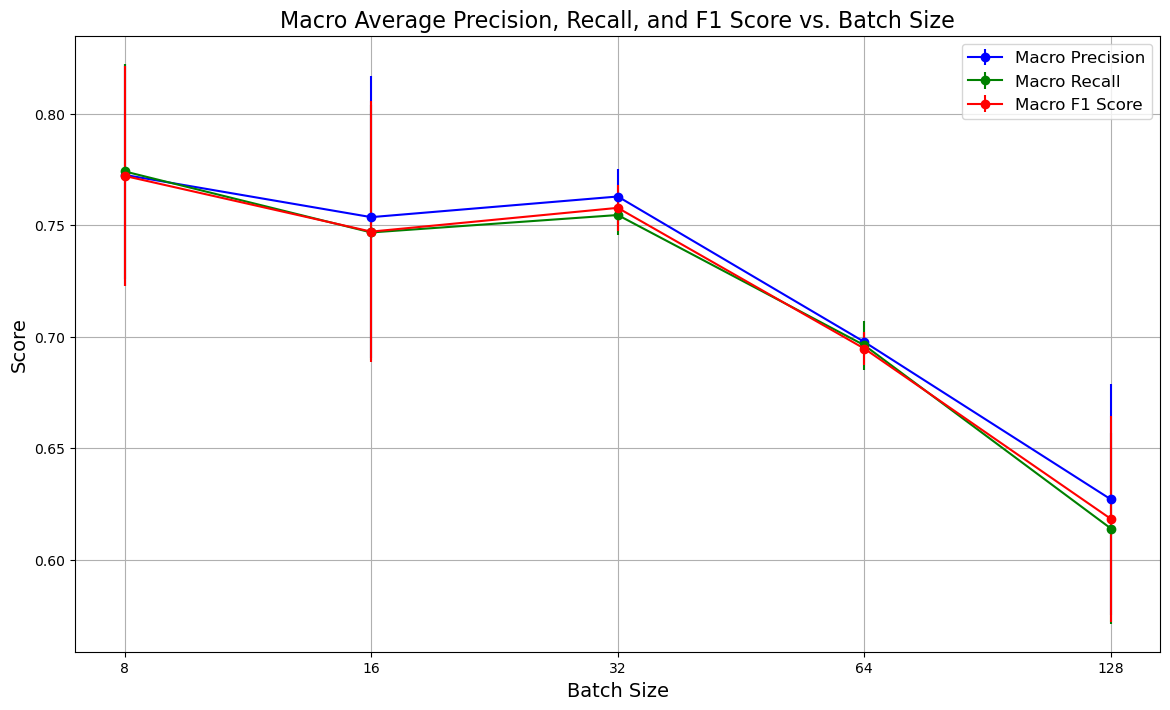

In [3]:
# Convert batch sizes to strings for categorical x-axis
batch_size_labels = list(map(str, batch_sizes))

plt.figure(figsize=(14, 8))

# Precision with a specific color
plt.errorbar(batch_size_labels, [mean_precisions[bs] for bs in batch_sizes], 
             yerr=[std_precisions[bs] for bs in batch_sizes], 
             label='Macro Precision', fmt='-o', color='blue')

# Recall with a different color
plt.errorbar(batch_size_labels, [mean_recalls[bs] for bs in batch_sizes], 
             yerr=[std_recalls[bs] for bs in batch_sizes], 
             label='Macro Recall', fmt='-o', color='green')

# F1 Score with another color
plt.errorbar(batch_size_labels, [mean_f1s[bs] for bs in batch_sizes], 
             yerr=[std_f1s[bs] for bs in batch_sizes], 
             label='Macro F1 Score', fmt='-o', color='red')

# Add labels and title with larger font size
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Macro Average Precision, Recall, and F1 Score vs. Batch Size', fontsize=16)

# Add legend with larger font size
plt.legend(fontsize=12)

# Grid with default settings
plt.grid(True)

# Save the plot to a file with higher resolution
plt.savefig('smm4h_top3_f1_vs_batchsize_test.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()